In [1]:
import datetime

from tqdm import keras

print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-09-09 17:38:03.799278


In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        print(e)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)


Num GPUs Available:  1
2.10.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import layers

In [4]:
file_path= '../pizza_steak'
train_path = file_path + '/train/'
test_path = file_path + '/test/'

In [5]:
import os
for dirpath,dirnames, filenames in os.walk(file_path):
    print(f'Directory {dirpath+"/"} has {len(dirnames)} directories and {len(filenames)} files')

Directory ../pizza_steak/ has 2 directories and 0 files
Directory ../pizza_steak\test/ has 2 directories and 0 files
Directory ../pizza_steak\test\pizza/ has 0 directories and 250 files
Directory ../pizza_steak\test\steak/ has 0 directories and 250 files
Directory ../pizza_steak\train/ has 2 directories and 0 files
Directory ../pizza_steak\train\pizza/ has 0 directories and 750 files
Directory ../pizza_steak\train\steak/ has 0 directories and 750 files


In [6]:
class_names=['Pizza','Steak']

In [7]:
def extract_files(file_path,x_dict):
    for dirpath,dirnames, filenames in os.walk(file_path):
        for file in os.listdir(dirpath):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                x_dict['images'].append(dirpath + '/'+  file)
                x_dict['labels'].append(dirpath.split('/')[-1])

In [8]:
import copy

train_dict = {
    'images': [],
    'labels': []
}
test_dict = copy.deepcopy(train_dict)

extract_files(train_path,train_dict)
extract_files(test_path,test_dict)

In [9]:
print(f'train data : {len(train_dict["labels"])} \ntest data : { len(test_dict["labels"])}')

train data : 1500 
test data : 500


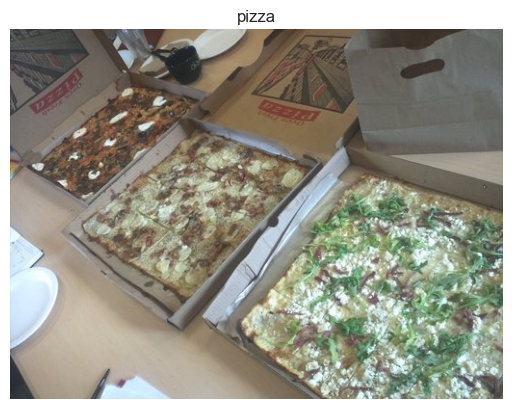

In [10]:
import random
rand_nb = random.randint(0,len(train_dict['images'])-1)
image = train_dict['images'][rand_nb]
label = train_dict['labels'][rand_nb]

img = plt.imread(image)

plt.imshow(img)
plt.title(f'{label}')
plt.axis('off');

In [11]:
IMG_SIZE = 224

In [12]:
def process_dataset(x, y):
    label = y
    if label == 'pizza':
        integer_label = 0
    else:
        integer_label = 1

    image = tf.io.read_file(x)
    image = tf.image.decode_jpeg(image, channels=3) # needed to specify channels
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32)  # Cast to float32 for normalization
    return image, integer_label

def scale(image, label):
    return image / 255, label

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((train_dict['images'], train_dict['labels']))

train_ds = train_ds.map(process_dataset).shuffle(1000).map(scale).batch(batch_size=32).cache().prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_dict['images'], test_dict['labels']))
test_ds = test_ds.map(process_dataset).shuffle(1000).map(scale).batch(batch_size=32).cache().prefetch(tf.data.AUTOTUNE)

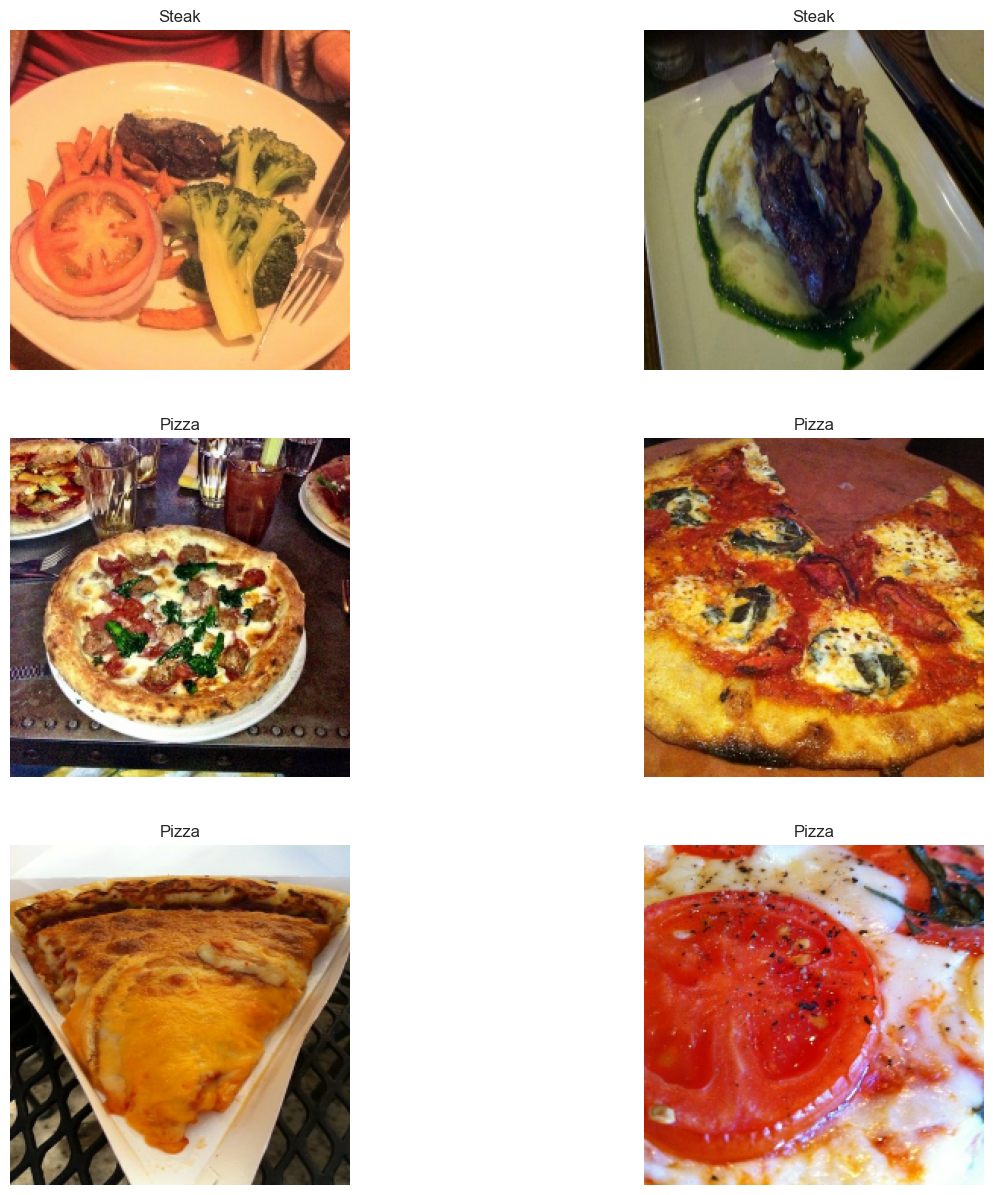

In [14]:
for batch_images, batch_labels in train_ds.take(1):
    plt.figure(figsize=(15, 15))
    for i in range(6):
        plt.subplot(3, 2, i + 1)
        plt.imshow(batch_images[i])
        plt.title(class_names[batch_labels[i]])
        plt.axis('off')

In [15]:
from keras import layers

In [16]:
# CROP_SIZE = 180
layer_augmentation = tf.keras.Sequential([
    # layers.RandomCrop(CROP_SIZE,CROP_SIZE), ## gives a graph error execution
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
])

In [17]:
model = tf.keras.models.Sequential([
    layer_augmentation,
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(filters=32, kernel_size=(5,2), activation='relu'),
    layers.MaxPooling2D(pool_size=(3)),
    layers.Conv2D(filters=64, kernel_size=(7,1), activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),  # To maintain the increased size
    layers.MaxPooling2D(pool_size=(3)),
    layers.Flatten(),
    layers.Dense(units=1, activation='sigmoid')
])



In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=tf.keras.losses.binary_crossentropy,
               metrics=['accuracy'])

In [19]:
with tf.device('/GPU:0'):  # Use the first GPU

    history = model.fit(train_ds,
                          epochs=10,
                        validation_data=test_ds
                          )
    keys_to_delete = ['loss', 'val_loss'] 
    hist = pd.DataFrame(history.history)
    loss_hist = hist[keys_to_delete]
    hist.drop(keys_to_delete, axis=1, inplace=True)

    # for key in keys_to_delete:
    #     if key in history.history:
    #         del history.history[key]

Epoch 1/10
47/47 [==============================] - 27s 351ms/step - loss: 0.6129 - accuracy: 0.6433 - val_loss: 0.4179 - val_accuracy: 0.8260
Epoch 2/10
47/47 [==============================] - 11s 240ms/step - loss: 0.4652 - accuracy: 0.7700 - val_loss: 0.4257 - val_accuracy: 0.8140
Epoch 3/10
47/47 [==============================] - 11s 242ms/step - loss: 0.4565 - accuracy: 0.7953 - val_loss: 0.3826 - val_accuracy: 0.8360
Epoch 4/10
47/47 [==============================] - 11s 244ms/step - loss: 0.4336 - accuracy: 0.8020 - val_loss: 0.3970 - val_accuracy: 0.8400
Epoch 5/10
47/47 [==============================] - 11s 244ms/step - loss: 0.4168 - accuracy: 0.8227 - val_loss: 0.3293 - val_accuracy: 0.8660
Epoch 6/10
47/47 [==============================] - 12s 248ms/step - loss: 0.3890 - accuracy: 0.8387 - val_loss: 0.3235 - val_accuracy: 0.8640
Epoch 7/10
47/47 [==============================] - 11s 240ms/step - loss: 0.3804 - accuracy: 0.8420 - val_loss: 0.2893 - val_accuracy: 0.8820

In [20]:
hist

,accuracy,val_accuracy
0,0.643333,0.826
1,0.770000,0.814
2,0.795333,0.836
3,0.802000,0.840
4,0.822667,0.866
5,0.838667,0.864
6,0.842000,0.882
7,0.849333,0.874
8,0.856667,0.864
9,0.850667,0.856


<Axes: >

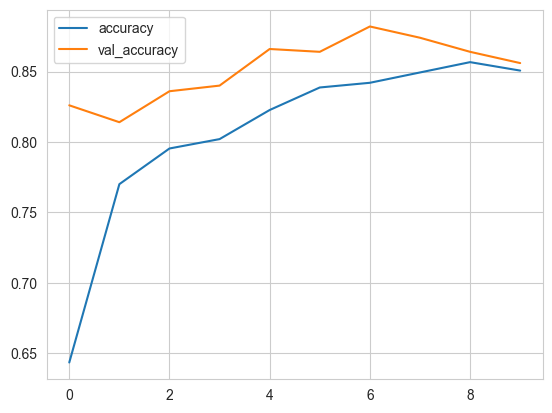

In [21]:
hist.plot()

<Axes: >

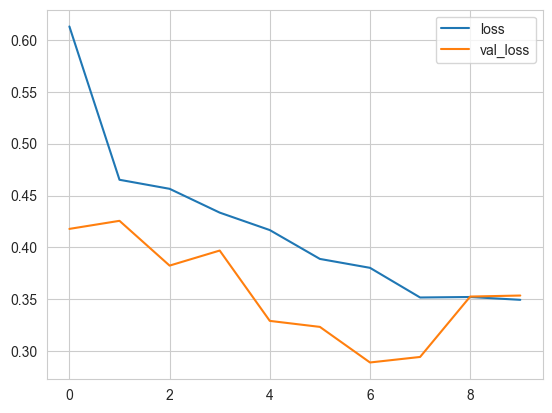

In [22]:
loss_hist.plot()